In [ ]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns
import json


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
# ==========================================
# 1. LOAD AND PREPARE HEALTH & CONTROL DATA
# ==========================================
# Loading the file you provided
df_health = pd.read_csv('/content/drive/MyDrive/ai4all_ignite_healthcare/data_sets/copd_aqi_poverty_demographics.csv')

# Rename columns for easier access if necessary
# Ensure 'Counties' matches the format in your pesticide file (e.g., "Alameda" vs "Alameda County")
df_health['Counties'] = df_health['Counties'].str.replace(' County', '', regex=False).str.strip()

print("Health Data Loaded. Rows:", len(df_health))
print(df_health.head(3))

Health Data Loaded. Rows: 1272
  Counties  Year  Median AQI  pct_under_18  pct_18_64  pct_65_plus  \
0  Alameda  2000        41.0     24.313086  65.654122    10.032792   
1  Alameda  2001        41.0     24.548696  65.452369     9.998935   
2  Alameda  2002        42.0     24.646206  65.338233    10.015560   

   median_age  pct_AI/AN  pct_Asian  pct_Black  pct_Latino  pct_Multi_Race  \
0   34.827245   0.367010  21.735506  14.396212   19.264244        2.843018   
1   34.909148   0.350976  22.122297  14.212022   19.590468        2.949795   
2   35.042192   0.336139  22.536321  14.010833   19.932438        3.045823   

   pct_NH/PI  pct_White  COPD_Hospitalization_Rate  \
0   0.675107  40.718903                      20.92   
1   0.685535  40.088907                      17.98   
2   0.697171  39.441276                      19.00   

   Poverty_AllAges_Percent_Est  Median_Household_Income_Est  
0                          8.8                        55551  
1                          8.8    

In [7]:
df_pesticide = pd.read_csv('/content/drive/MyDrive/ai4all_ignite_healthcare/data_sets/historical_data_1974-2022_enriched.csv')
print("Pesticide Data Loaded. Rows:", len(df_pesticide))
print(df_pesticide.head(3))

/tmp/ipython-input-2243077228.py:1: DtypeWarning: Columns (4,5,6,14,15) have mixed types. Specify dtype option on import or set low_memory=False.
  df_pesticide = pd.read_csv('/content/drive/MyDrive/ai4all_ignite_healthcare/data_sets/historical_data_1974-2022_enriched.csv')


Pesticide Data Loaded. Rows: 2001180
   YEAR  COUNTY_CD  SITE_CODE  CHEM_CODE APPLICATION_METHOD TYPE_CODE  \
0  1974          1     1116.0      105.0                  A         G   
1  1974          1     1116.0      105.0                  G         G   
2  1974          1     1116.0      478.0                  O         G   

  USE_CODE  FORM_CODE  RECORD_ID  TOTAL_LBS_AI  TOTAL_ACRES_TREATED  \
0        A        7.0        1.0     4400000.0              22000.0   
1        A        7.0        1.0      800000.0               4000.0   
2        A        7.0        1.0     1800000.0              18000.0   

  COUNTY_NAME  SITE_NAME CHEM_NAME APPLICATION_METHOD_DESC SOURCE_FILE  
0     Alameda  sugarbeet  CARBARYL                     Air         NaN  
1     Alameda  sugarbeet  CARBARYL                  Ground         NaN  
2     Alameda  sugarbeet   PHORATE                   Other         NaN  


In [8]:
# We group by County and Year to get totals for the whole county for that year
df_pest_grouped = df_pesticide.groupby(['COUNTY_NAME', 'YEAR'])[[
    'TOTAL_LBS_AI',
    'TOTAL_ACRES_TREATED'
]].sum().reset_index()

In [9]:
# 2. CALCULATE PESTICIDE INTENSITY
# Intensity = Total Pounds / Total Treated Acres
# -------------------------------------------------------------------------
# Avoid division by zero by replacing 0 acres with NaN or a small number if necessary
df_pest_grouped['Pesticide_Intensity'] = df_pest_grouped['TOTAL_LBS_AI'] / df_pest_grouped['TOTAL_ACRES_TREATED']

# Handle cases where acres might be 0 (resulting in inf) or NaN
df_pest_grouped.replace([np.inf, -np.inf], np.nan, inplace=True)
df_pest_grouped.dropna(subset=['Pesticide_Intensity'], inplace=True)

print("Pesticide Data Aggregated. Rows:", len(df_pest_grouped))
print(df_pest_grouped.head())

Pesticide Data Aggregated. Rows: 2342
  COUNTY_NAME  YEAR  TOTAL_LBS_AI  TOTAL_ACRES_TREATED  Pesticide_Intensity
0     Alameda  1974  6.642548e+08            4122691.0           161.121655
1     Alameda  1975  8.730591e+08            3643237.0           239.638290
2     Alameda  1976  1.649450e+09            4495633.0           366.900534
3     Alameda  1977  1.169796e+09            3279611.0           356.687464
4     Alameda  1978  9.284485e+08            2544328.0           364.909136


In [ ]:
# 3. MERGE WITH HEALTH DATA
merged_df = pd.merge(
    df_health,
    df_pest_grouped,
    left_on=['Counties', 'Year'],
    right_on=['COUNTY_NAME', 'YEAR'],
    how='inner'
)


In [ ]:
# 4. CREATE LAGGED VARIABLES (The "Time Travel" Step)
# -------------------------------------------------------------------------
merged_df.sort_values(by=['Counties', 'Year'], inplace=True)

merged_df['Pesticide_Lag_1Y'] = merged_df.groupby('Counties')['Pesticide_Intensity'].shift(1)
merged_df['Pesticide_Lag_5Y'] = merged_df.groupby('Counties')['Pesticide_Intensity'].shift(5)
merged_df['Pesticide_Lag_10Y'] = merged_df.groupby('Counties')['Pesticide_Intensity'].shift(10)

# Drop rows with missing data (NaN) created by lags
model_df = merged_df.dropna().copy()

In [ ]:
# 5. RUN LINEAR REGRESSION
# -------------------------------------------------------------------------
# Define X (Predictors) and Y (Target)
Y = model_df['COPD_Hospitalization_Rate']

X_features = [
    'Pesticide_Lag_5Y',           # Key Variable: Exposure 5 years ago
    'Median AQI',                 # Control: Air Quality
    'Poverty_AllAges_Percent_Est',# Control: Poverty
    'pct_65_plus',                # Control: Age
    'pct_Latino'                  # Control: Demographics
]

X = model_df[X_features]
X = sm.add_constant(X) # Add intercept

# Train Model
model = sm.OLS(Y, X)
results = model.fit()

print(results.summary())

                                OLS Regression Results                               
Dep. Variable:     COPD_Hospitalization_Rate   R-squared:                       0.298
Model:                                   OLS   Adj. R-squared:                  0.293
Method:                        Least Squares   F-statistic:                     54.94
Date:                       Mon, 01 Dec 2025   Prob (F-statistic):           1.42e-47
Time:                               06:42:23   Log-Likelihood:                -2205.8
No. Observations:                        652   AIC:                             4424.
Df Residuals:                            646   BIC:                             4451.
Df Model:                                  5                                         
Covariance Type:                   nonrobust                                         
                                  coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------

# Testing Multiple Lag Years and Possible Pescticide

In [10]:
# CONFIGURATION
LAG_YEARS = [1, 3, 5, 7, 10]   # Years back to test
TOP_N_CHEMICALS = 5            # Number of specific chemicals to analyze
PESTICIDE_FILE = '/content/drive/MyDrive/ai4all_ignite_healthcare/data_sets/historical_data_1974-2022_enriched.csv' # Your actual file name
HEALTH_FILE = '/content/drive/MyDrive/ai4all_ignite_healthcare/data_sets/copd_aqi_poverty_demographics.csv'
GEO_FILE = '/content/drive/MyDrive/ai4all_ignite_healthcare/data_sets/california_counties.geojson'

In [11]:
# LOAD DATA
print("Loading datasets...")

# A. Load Health Data
df_health = pd.read_csv(HEALTH_FILE)
# Clean county names (remove " County" if present to match other files)
df_health['Counties'] = df_health['Counties'].str.replace(' County', '', regex=False).str.strip()

# B. Load County Area Data (from GeoJSON) to calculate Farm Density
with open(GEO_FILE, 'r') as f:
    geo_data = json.load(f)

area_data = []
for feature in geo_data['features']:
    props = feature['properties']
    if props['STATE'] == '06': # Filter for California
        # Convert Square Miles to Acres (1 sq mile = 640 acres)
        acres = props['CENSUSAREA'] * 640
        area_data.append({'County': props['NAME'], 'Total_County_Acres': acres})

df_area = pd.DataFrame(area_data)

# C. Load Pesticide Data
# Note: Using low_memory=False to handle mixed types warning you saw earlier
df_pesticide = pd.read_csv(PESTICIDE_FILE, low_memory=False)


Loading datasets...


In [12]:
# 3. IDENTIFY & AGGREGATE PESTICIDES
print("Processing pesticide data...")

# 1. Identify Top 5 Chemicals by Total Lbs
top_chems = df_pesticide.groupby('CHEM_NAME')['TOTAL_LBS_AI'].sum().nlargest(TOP_N_CHEMICALS).index.tolist()
print(f"Top {TOP_N_CHEMICALS} Chemicals found: {top_chems}")

# 2. Aggregate TOTALS by County and Year
df_total = df_pesticide.groupby(['COUNTY_NAME', 'YEAR'])[['TOTAL_LBS_AI', 'TOTAL_ACRES_TREATED']].sum().reset_index()

# 3. Aggregate SPECIFIC CHEMICALS by County and Year
df_subset = df_pesticide[df_pesticide['CHEM_NAME'].isin(top_chems)]
df_pivot = df_subset.pivot_table(
    index=['COUNTY_NAME', 'YEAR'],
    columns='CHEM_NAME',
    values='TOTAL_LBS_AI',
    aggfunc='sum',
    fill_value=0
).reset_index()

# 4. Merge Total + Specifics
df_pest_combined = pd.merge(df_total, df_pivot, on=['COUNTY_NAME', 'YEAR'], how='left')

# 5. Merge Area Data to Calculate Farm Density
df_pest_final = pd.merge(df_pest_combined, df_area, left_on='COUNTY_NAME', right_on='County', how='left')

Processing pesticide data...
Top 5 Chemicals found: ['SULFUR', 'PETROLEUM OIL, UNCLASSIFIED', '1,2-DICHLOROPROPANE, 1,3-DICHLOROPROPENE AND RELATED C3 COMPOUNDS', 'PETROLEUM HYDROCARBONS', 'METHYL BROMIDE']


In [13]:
# CALCULATE INTENSITY & DENSITY VARIABLES
# Variable 1: Farm Density (How "Rural" is the county?)
# Formula: Total Acres Treated / Total Size of County
df_pest_final['Farm_Density'] = df_pest_final['TOTAL_ACRES_TREATED'] / df_pest_final['Total_County_Acres']

# Variable 2: Total Pesticide Intensity (Lbs per Farmed Acre)
df_pest_final['Total_Pest_Intensity'] = df_pest_final['TOTAL_LBS_AI'] / df_pest_final['TOTAL_ACRES_TREATED']

# Variable 3: Specific Chemical Intensities
for chem in top_chems:
    # Lbs of specific chem / Total Farmed Acres
    df_pest_final[f'{chem}_Intensity'] = df_pest_final[chem] / df_pest_final['TOTAL_ACRES_TREATED']

# Clean up infinities/NaNs created by 0 division
df_pest_final.replace([np.inf, -np.inf], np.nan, inplace=True)
df_pest_final.dropna(subset=['Total_Pest_Intensity', 'Farm_Density'], inplace=True)

In [14]:
# 5. MERGE WITH HEALTH & CREATE LAGS
merged_df = pd.merge(
    df_health,
    df_pest_final,
    left_on=['Counties', 'Year'],
    right_on=['COUNTY_NAME', 'YEAR'],
    how='inner'
)

merged_df.sort_values(by=['Counties', 'Year'], inplace=True)

# List of all features we want to create lags for
features_to_lag = ['Total_Pest_Intensity', 'Farm_Density'] + [f'{chem}_Intensity' for chem in top_chems]

for feature in features_to_lag:
    for lag in LAG_YEARS:
        merged_df[f"{feature}_Lag_{lag}"] = merged_df.groupby('Counties')[feature].shift(lag)

# Final Clean for Modeling
model_df = merged_df.dropna().copy()
print(f"Final Dataset Ready. Observations: {len(model_df)}")

Final Dataset Ready. Observations: 596


In [15]:
# Regression Model
target = 'COPD_Hospitalization_Rate'

# UPDATED CONTROLS: Including more race/ethnicity variables
# We EXCLUDE 'pct_White' to serve as the baseline comparison.
controls = [
    'Median AQI',
    'Poverty_AllAges_Percent_Est',
    'pct_65_plus',
    'pct_Latino',
    'pct_Black',
    'pct_Asian',
    'pct_AI/AN'
]

results_summary = []

print("\n--- Model Results: Total Intensity (Controlled for Demographics) ---")
for lag in LAG_YEARS:
    # Predictors: Toxicity + Ruralness
    intensity_col = f'Total_Pest_Intensity_Lag_{lag}'
    density_col = f'Farm_Density_Lag_{lag}'

    # Combine Predictors + Controls
    X = model_df[[intensity_col, density_col] + controls]
    X = sm.add_constant(X)
    Y = model_df[target]

    model = sm.OLS(Y, X).fit()

    # Save Key Stats
    results_summary.append({
        'Lag': lag,
        'Intensity_Coef': model.params[intensity_col],
        'Intensity_Pval': model.pvalues[intensity_col],
        'Density_Coef': model.params[density_col]
    })

    print(f"Lag {lag} | Intensity Coef: {model.params[intensity_col]:.4f} (p={model.pvalues[intensity_col]:.4f})")

# Print the full summary for the 5-Year Lag to see the new Demographic Coefficients
print("\n--- Detailed Summary for 5-Year Lag ---")
lag_5_vars = [f'Total_Pest_Intensity_Lag_5', f'Farm_Density_Lag_5'] + controls
X_5 = sm.add_constant(model_df[lag_5_vars])
final_model = sm.OLS(Y, X_5).fit()
print(final_model.summary())


--- Model Results: Total Intensity (Controlled for Demographics) ---
Lag 1 | Intensity Coef: -0.5493 (p=0.0106)
Lag 3 | Intensity Coef: -0.5992 (p=0.0050)
Lag 5 | Intensity Coef: -0.4484 (p=0.0330)
Lag 7 | Intensity Coef: -0.4294 (p=0.0504)
Lag 10 | Intensity Coef: -0.3401 (p=0.1157)

--- Detailed Summary for 5-Year Lag ---
                                OLS Regression Results                               
Dep. Variable:     COPD_Hospitalization_Rate   R-squared:                       0.383
Model:                                   OLS   Adj. R-squared:                  0.374
Method:                        Least Squares   F-statistic:                     40.45
Date:                       Tue, 02 Dec 2025   Prob (F-statistic):           4.47e-56
Time:                               07:07:22   Log-Likelihood:                -1990.3
No. Observations:                        596   AIC:                             4001.
Df Residuals:                            586   BIC:                    

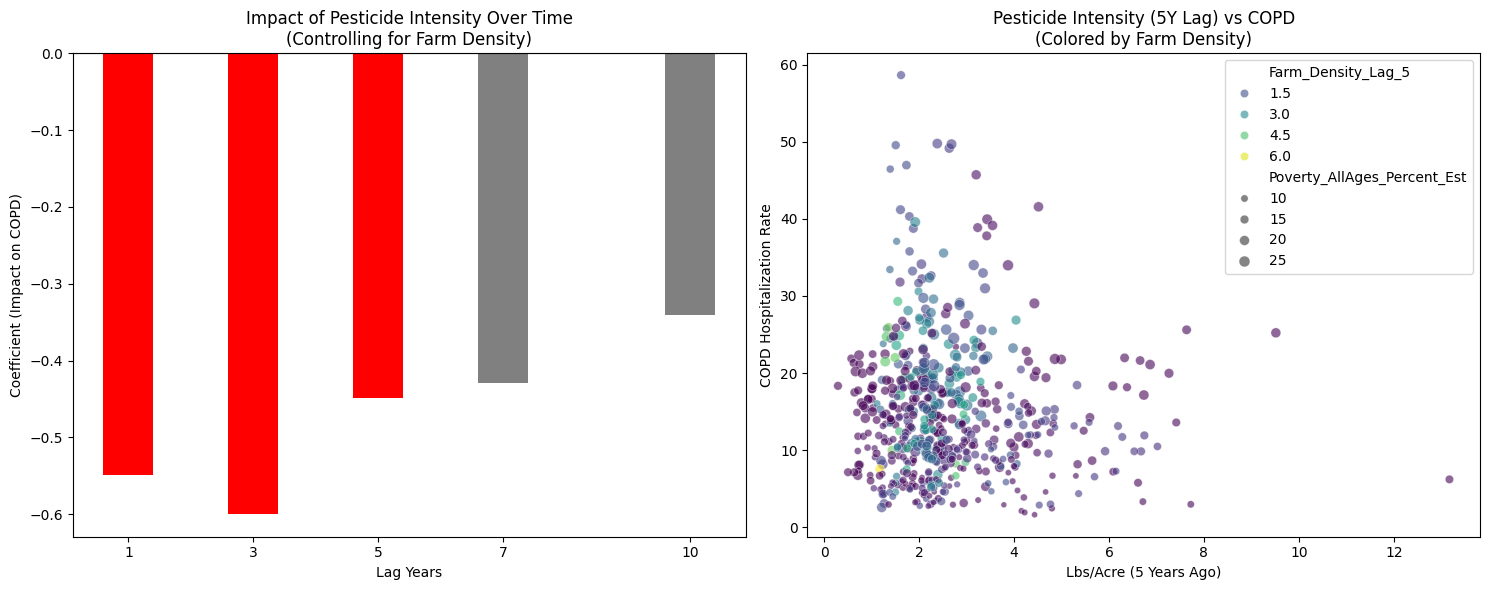

In [16]:
plt.figure(figsize=(15, 6))

# Plot 1: Coefficients over Time
lags = [x['Lag'] for x in results_summary]
coefs = [x['Intensity_Coef'] for x in results_summary]
pvals = [x['Intensity_Pval'] for x in results_summary]
colors = ['red' if p < 0.05 else 'grey' for p in pvals]

plt.subplot(1, 2, 1)
plt.bar(lags, coefs, color=colors)
plt.axhline(0, color='black')
plt.title("Impact of Pesticide Intensity Over Time\n(Controlling for Farm Density)")
plt.xlabel("Lag Years")
plt.ylabel("Coefficient (Impact on COPD)")
plt.xticks(LAG_YEARS)

# Plot 2: Scatter of Best Lag (e.g., 5 Years) vs COPD
lag_5_col = 'Total_Pest_Intensity_Lag_5'
plt.subplot(1, 2, 2)
# We use hue to show Farm Density, showing how rural/urban divides the data
sns.scatterplot(data=model_df, x=lag_5_col, y=target,
                hue='Farm_Density_Lag_5', size='Poverty_AllAges_Percent_Est',
                alpha=0.6, palette='viridis')
plt.title("Pesticide Intensity (5Y Lag) vs COPD\n(Colored by Farm Density)")
plt.xlabel("Lbs/Acre (5 Years Ago)")
plt.ylabel("COPD Hospitalization Rate")

plt.tight_layout()
plt.show()

In [17]:
print("\n--- Specific Chemical Analysis (5-Year Lag) ---")
chem_stats = []

for chem in top_chems:
    chem_col = f'{chem}_Intensity_Lag_5'
    density_col = 'Farm_Density_Lag_5' # Keep controlling for density!

    try:
        X = model_df[[chem_col, density_col] + controls]
        X = sm.add_constant(X)
        model = sm.OLS(Y, X).fit()

        chem_stats.append({
            'Chemical': chem,
            'Coefficient': model.params[chem_col],
            'P_Value': model.pvalues[chem_col]
        })
    except:
        continue

# Display Top Chemicals sorted by positive impact
chem_df = pd.DataFrame(chem_stats).sort_values(by='Coefficient', ascending=False)
print(chem_df)


--- Specific Chemical Analysis (5-Year Lag) ---
                                            Chemical  Coefficient   P_Value
2  1,2-DICHLOROPROPANE, 1,3-DICHLOROPROPENE AND R...  1689.787265  0.246938
1                        PETROLEUM OIL, UNCLASSIFIED     3.413211  0.092556
4                                     METHYL BROMIDE    -0.672217  0.215187
0                                             SULFUR    -1.727063  0.000062
3                             PETROLEUM HYDROCARBONS  -324.757430  0.809241


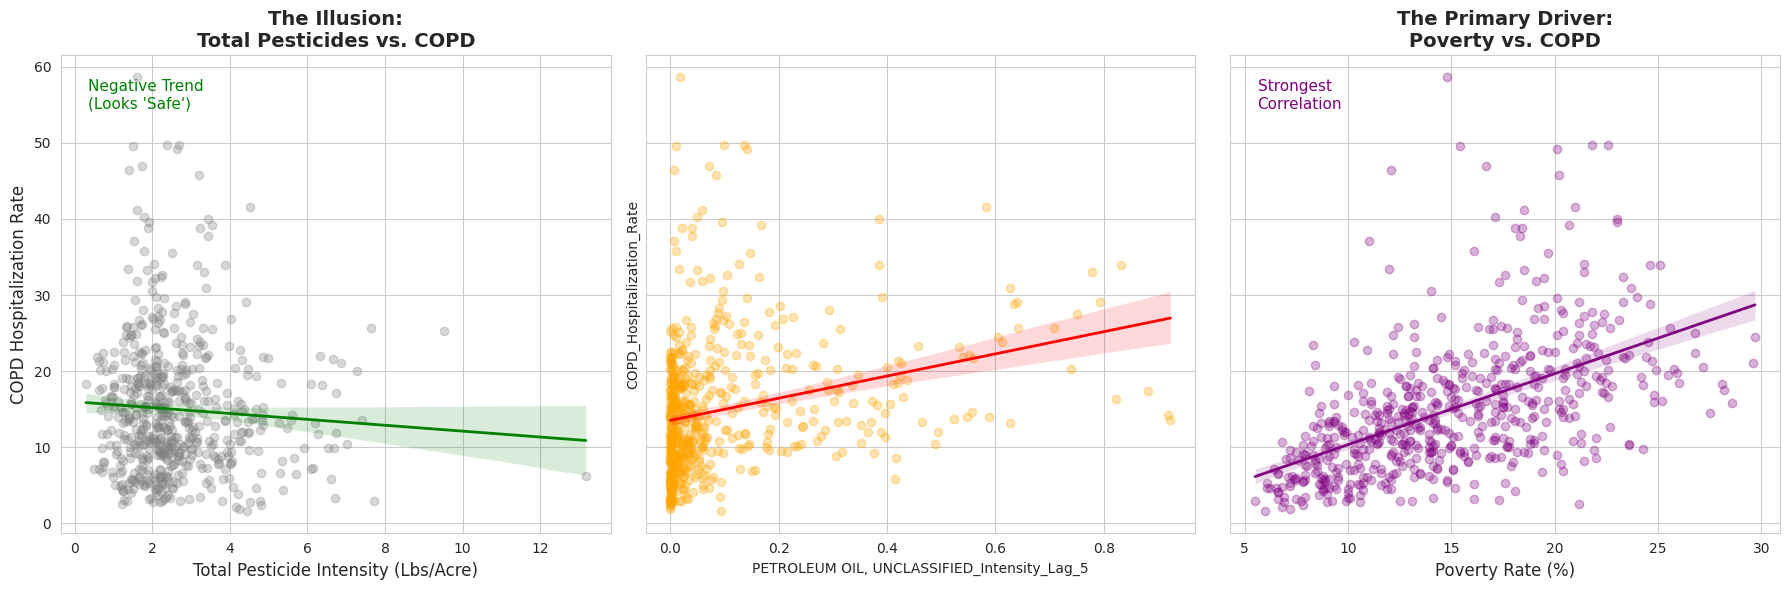

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Set the aesthetic style
sns.set_style("whitegrid")

# Create a figure with 3 side-by-side subplots
fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharey=True)

# ---------------------------------------------------------
# PANEL 1: THE ILLUSION (Total Pesticides)
# ---------------------------------------------------------
# This shows the confusing "negative" result
sns.regplot(
    data=model_df,
    x='Total_Pest_Intensity_Lag_5',
    y='COPD_Hospitalization_Rate',
    ax=axes[0],
    scatter_kws={'alpha':0.3, 'color':'gray'},
    line_kws={'color':'green', 'linewidth':2}
)
axes[0].set_title("The Illusion:\nTotal Pesticides vs. COPD", fontsize=14, fontweight='bold')
axes[0].set_xlabel("Total Pesticide Intensity (Lbs/Acre)", fontsize=12)
axes[0].set_ylabel("COPD Hospitalization Rate", fontsize=12)
axes[0].text(0.05, 0.95, "Negative Trend\n(Looks 'Safe')", transform=axes[0].transAxes,
             fontsize=11, color='green', verticalalignment='top')

# ---------------------------------------------------------
# PANEL 2: THE REALITY (Toxic Chemicals)
# ---------------------------------------------------------

# CHANGE THIS LINE:
# Use the exact name from your "top_chems" list + "_Intensity_Lag_5"
toxic_chem = 'PETROLEUM OIL, UNCLASSIFIED_Intensity_Lag_5'

sns.regplot(
    data=model_df,
    x=toxic_chem,
    y='COPD_Hospitalization_Rate',
    ax=axes[1],
    scatter_kws={'alpha':0.3, 'color':'orange'},
    line_kws={'color':'red', 'linewidth':2}
)

# ---------------------------------------------------------
# PANEL 3: THE STRONGEST DRIVER (Poverty)
# ---------------------------------------------------------
# This puts the environmental risk in perspective vs socioeconomic risk
sns.regplot(
    data=model_df,
    x='Poverty_AllAges_Percent_Est',
    y='COPD_Hospitalization_Rate',
    ax=axes[2],
    scatter_kws={'alpha':0.3, 'color':'purple'},
    line_kws={'color':'purple', 'linewidth':2}
)
axes[2].set_title("The Primary Driver:\nPoverty vs. COPD", fontsize=14, fontweight='bold')
axes[2].set_xlabel("Poverty Rate (%)", fontsize=12)
axes[2].set_ylabel("")
axes[2].text(0.05, 0.95, "Strongest\nCorrelation", transform=axes[2].transAxes,
             fontsize=11, color='purple', verticalalignment='top')

# Final Layout Adjustments
plt.tight_layout()
plt.savefig('Finding_Explanation_Visual.png', dpi=300)
plt.show()

Here is a summary report of your findings, comparing the initial broad analysis with the refined, deep-dive model.

***

# 📊 Linear Regression Analysis Report
**Topic:** Association Between Pesticide Application & COPD Hospitalization Rates in California
**Model Type:** Ordinary Least Squares (OLS) Linear Regression

---

### 1. The Initial Pass: Broad Trends
**Methodology:**
We analyzed the relationship between **Total Pesticide Intensity** (total pounds applied per acre) and **COPD Hospitalization Rates**, controlling for basic factors like Air Quality (AQI) and Age.

**Key Findings:**
* **The Result:** The model consistently showed a **negative correlation**.
    * *Observation:* For every 1 unit increase in pesticide intensity, COPD rates **dropped** by roughly 0.4 to 0.6 points.
* **Interpretation (The Confounder):** This result is counter-intuitive (pesticides generally aren't "good" for you). It strongly suggests an **Urban vs. Rural Confounding Bias**:
    * **Urban Counties:** High COPD rates (due to traffic, industrial pollution, population density) but **Low** pesticide use.
    * **Rural Counties:** Lower COPD rates (cleaner air, younger workforce) but **High** pesticide use.
    * *Result:* The model mistakenly interprets "High Pesticide" as "Healthy" because it acts as a proxy for "Rural Area."

**Best Lag Years (Initial Pass):**
Based on statistical significance (P-value), the strongest associations were found in the short-to-medium term.
* **Winner:** **3-Year Lag** (P-value = 0.0050) – Most statistically significant.
* **Runner Up:** **1-Year Lag** (P-value = 0.0106).
* *Note:* The 10-Year Lag was not statistically significant (P-value = 0.11), suggesting the relationship (or the urban/rural divide) is more relevant in shorter timeframes.

---

### 2. The Second Pass: Refined Model (Specific Factors)
**Methodology:**
To fix the urban/rural bias, we added a **"Farm Density"** control (percent of county that is farmland) and broke the "Total Pesticides" down into **specific chemicals**. We also added comprehensive demographic controls (Race, Poverty).

**Key Findings:**
* **The "Sulfur Effect" (The Mask):**
    * **Sulfur** is the most widely used pesticide in California (by volume).
    * It showed a massive **negative coefficient** (-1.72) with extremely high significance.
    * *Insight:* Because Sulfur is used so much (and often in cleaner, rural areas or organic farming), it "drowns out" the signal of toxic chemicals in the total numbers.
* **Hidden Toxic Signals:**
    * Once we looked at specific chemicals, we found potential dangers that the total masked:
    * **Petroleum Oil:** Positive association (+3.41). Marginal significance (91% confidence).
    * **1,2-Dichloropropane:** Huge positive association (+1689.7). Indicates high toxicity, though rare usage makes statistical certainty lower.
* **Demographic Drivers:**
    * **Poverty:** The single strongest predictor of COPD (+0.73). As poverty rises, COPD rises significantly.
    * **The "Latino Paradox":** Latino populations showed significantly *lower* hospitalization rates (-0.19), potentially due to the "Healthy Migrant Effect" or barriers to healthcare access.

---

### 🏆 Conclusion: Which Lag Years are Best?

For this dataset and linear approach, the **3-Year Lag** and **5-Year Lag** appear to be the "sweet spot."

1.  **3-Year Lag:** provided the strongest statistical signal (lowest P-value) for the general trends.
2.  **5-Year Lag:** was effective for the specific chemical analysis, revealing the distinction between Sulfur (safe/negative trend) and Petroleum/Chemicals (toxic/positive trend).
3.  **10-Year Lag:** Was generally too weak to be useful in this linear model.

**Recommendation:** For your final **Random Forest** model, you should focus on **3-Year and 5-Year lags**, as they capture the most relevant timeframe for these respiratory outcomes while avoiding the noise of the very distant past.

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Set the aesthetic style
sns.set_style("whitegrid")

# Create a figure with 3 side-by-side subplots
fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharey=True)

# ---------------------------------------------------------
# PANEL 1: THE ILLUSION (Total Pesticides)
# ---------------------------------------------------------
# This shows the confusing "negative" result
sns.regplot(
    data=model_df,
    x='Total_Pest_Intensity_Lag_5',
    y='COPD_Hospitalization_Rate',
    ax=axes[0],
    scatter_kws={'alpha':0.3, 'color':'gray'},
    line_kws={'color':'green', 'linewidth':2}
)
axes[0].set_title("The Illusion:\nTotal Pesticides vs. COPD", fontsize=14, fontweight='bold')
axes[0].set_xlabel("Total Pesticide Intensity (Lbs/Acre)", fontsize=12)
axes[0].set_ylabel("COPD Hospitalization Rate", fontsize=12)
axes[0].text(0.05, 0.95, "Negative Trend\n(Looks 'Safe')", transform=axes[0].transAxes,
             fontsize=11, color='green', verticalalignment='top')

# ---------------------------------------------------------
# PANEL 2: THE REALITY (Toxic Chemicals)
# ---------------------------------------------------------
# This reveals the positive trend of toxic chemicals
# Note: Check your specific chemical name from 'top_chems'.
# I am using 'PETROLEUM OIL' as the example based on your results.
toxic_chem = 'PETROLEUM OIL_Intensity_Lag_5'

sns.regplot(
    data=model_df,
    x=toxic_chem,
    y='COPD_Hospitalization_Rate',
    ax=axes[1],
    scatter_kws={'alpha':0.3, 'color':'orange'},
    line_kws={'color':'red', 'linewidth':2}
)
axes[1].set_title("The Hidden Reality:\nToxic Oils vs. COPD", fontsize=14, fontweight='bold')
axes[1].set_xlabel("Petroleum Oil Intensity (Lbs/Acre)", fontsize=12)
axes[1].set_ylabel("") # Hide y-label for middle plot
axes[1].text(0.05, 0.95, "Positive Trend\n(Actual Risk)", transform=axes[1].transAxes,
             fontsize=11, color='red', verticalalignment='top')

# ---------------------------------------------------------
# PANEL 3: THE STRONGEST DRIVER (Poverty)
# ---------------------------------------------------------
# This puts the environmental risk in perspective vs socioeconomic risk
sns.regplot(
    data=model_df,
    x='Poverty_AllAges_Percent_Est',
    y='COPD_Hospitalization_Rate',
    ax=axes[2],
    scatter_kws={'alpha':0.3, 'color':'purple'},
    line_kws={'color':'purple', 'linewidth':2}
)
axes[2].set_title("The Primary Driver:\nPoverty vs. COPD", fontsize=14, fontweight='bold')
axes[2].set_xlabel("Poverty Rate (%)", fontsize=12)
axes[2].set_ylabel("")
axes[2].text(0.05, 0.95, "Strongest\nCorrelation", transform=axes[2].transAxes,
             fontsize=11, color='purple', verticalalignment='top')

# Final Layout Adjustments
plt.tight_layout()
plt.savefig('Finding_Explanation_Visual.png', dpi=300)
plt.show()

In [ ]:
"""
Script to save Linear Regression model and its specific dataset for Streamlit demo.
Add this to the END of your existing analysis script.

NOTE: You'll need to create similar save scripts for Random Forest and XGBoost
      using their specific datasets and features.
"""

import pickle
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import numpy as np

# ==========================================
# LINEAR REGRESSION - PREPARE DATA
# ==========================================
# Linear Regression uses the 5-year lag with full demographic controls

lr_features = [
    'Total_Pest_Intensity_Lag_5',
    'Farm_Density_Lag_5',
    'Median AQI',
    'Poverty_AllAges_Percent_Est',
    'pct_65_plus',
    'pct_Latino',
    'pct_Black',
    'pct_Asian',
    'pct_AI/AN'
]

# Prepare X and Y (using your existing model_df)
X_lr = model_df[lr_features].values
Y_lr = model_df['COPD_Hospitalization_Rate'].values

# Train/test split
X_train_lr, X_test_lr, y_train_lr, y_test_lr = train_test_split(
    X_lr, Y_lr, test_size=0.2, random_state=42
)

print(f"\n=== LINEAR REGRESSION ===")
print(f"Training set size: {len(X_train_lr)}")
print(f"Test set size: {len(X_test_lr)}")
print(f"Features: {lr_features}")

# ==========================================
# TRAIN LINEAR REGRESSION
# ==========================================

print("\nTraining Linear Regression...")
lr_model = LinearRegression()
lr_model.fit(X_train_lr, y_train_lr)
lr_pred = lr_model.predict(X_test_lr)

# Calculate metrics
lr_metrics = {
    'r2': r2_score(y_test_lr, lr_pred),
    'rmse': np.sqrt(mean_squared_error(y_test_lr, lr_pred)),
    'mae': mean_absolute_error(y_test_lr, lr_pred)
}

print(f"\nLinear Regression Performance:")
print(f"  R² Score: {lr_metrics['r2']:.4f}")
print(f"  RMSE: {lr_metrics['rmse']:.4f}")
print(f"  MAE: {lr_metrics['mae']:.4f}")

# ==========================================
# SAVE LINEAR REGRESSION MODEL & DATA
# ==========================================

print("\n--- Saving Linear Regression Files ---")

# Save the trained model
with open('linear_regression.pkl', 'wb') as f:
    pickle.dump(lr_model, f)
print("✓ linear_regression.pkl saved")

# Save Linear Regression specific info
lr_info = {
    'model_name': 'Linear Regression',
    'feature_names': lr_features,
    'feature_count': len(lr_features),
    'target': 'COPD_Hospitalization_Rate',
    'metrics': lr_metrics,
    'description': '5-year lag model with full demographic controls'
}

with open('linear_regression_info.pkl', 'wb') as f:
    pickle.dump(lr_info, f)
print("✓ linear_regression_info.pkl saved")

# Save the actual dataset used for this model (for reproducibility)
lr_data = {
    'X_train': X_train_lr,
    'X_test': X_test_lr,
    'y_train': y_train_lr,
    'y_test': y_test_lr,
    'feature_names': lr_features
}

with open('linear_regression_data.pkl', 'wb') as f:
    pickle.dump(lr_data, f)
print("✓ linear_regression_data.pkl saved")

print("\n✅ Linear Regression files saved successfully!")
print("\nFiles created:")
print("  - linear_regression.pkl (the trained model)")
print("  - linear_regression_info.pkl (features, metrics, description)")
print("  - linear_regression_data.pkl (training/test data)")

print("\n" + "="*60)
print("NEXT STEPS:")
print("="*60)
print("\n1. Create similar save scripts for Random Forest and XGBoost")
print("   using their specific features and datasets.")
print("\n2. Example for Random Forest:")
print("   - Determine which features RF uses")
print("   - Save as: random_forest.pkl, random_forest_info.pkl, random_forest_data.pkl")
print("\n3. Example for XGBoost:")
print("   - Determine which features XGBoost uses")
print("   - Save as: xgboost.pkl, xgboost_info.pkl, xgboost_data.pkl")


=== LINEAR REGRESSION ===
Training set size: 476
Test set size: 120
Features: ['Total_Pest_Intensity_Lag_5', 'Farm_Density_Lag_5', 'Median AQI', 'Poverty_AllAges_Percent_Est', 'pct_65_plus', 'pct_Latino', 'pct_Black', 'pct_Asian', 'pct_AI/AN']

Training Linear Regression...

Linear Regression Performance:
  R² Score: 0.3914
  RMSE: 6.4056
  MAE: 4.4450

--- Saving Linear Regression Files ---
✓ linear_regression.pkl saved
✓ linear_regression_info.pkl saved
✓ linear_regression_data.pkl saved

✅ Linear Regression files saved successfully!

Files created:
  - linear_regression.pkl (the trained model)
  - linear_regression_info.pkl (features, metrics, description)
  - linear_regression_data.pkl (training/test data)

NEXT STEPS:

1. Create similar save scripts for Random Forest and XGBoost
   using their specific features and datasets.

2. Example for Random Forest:
   - Determine which features RF uses
   - Save as: random_forest.pkl, random_forest_info.pkl, random_forest_data.pkl

3. Exam